In [9]:
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as int
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm

#### Making ODE and Integrating Forward

In [2]:
#Make a network 
class SimpleFeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, depth, output_dim, activation_func=nn.Tanh()):
        super(SimpleFeedforwardNN, self).__init__()

        layers = []
        layers.append(nn.Linear(input_dim, depth))
        layers.append(activation_func)

        for _ in range(hidden_layers):
            layers.append(nn.Linear(depth, depth))
            layers.append(activation_func)

        layers.append(nn.Linear(depth, output_dim))
        self.network = nn.Sequential(*layers)

        #Setting initial weights
        for m in self.network.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.2)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, x):
        return self.network(x)

In [4]:
class Simple_neural_ode(SimpleFeedforwardNN):
    def __init__(self, variables, hidden_layers=1, depth_of_layers=10):
        super().__init__(input_dim=variables, hidden_layers=hidden_layers, depth=depth_of_layers, 
                         output_dim=variables, activation_func=nn.ELU())

class Simple_neural_ode():
    def __init__(self, variables, hidden_layers=1, depth_of_layers=10):
        super().__init__()

        #Define attributes of our NeuralODE
        self.depth              = depth_of_layers #Depth is number of neurons per hidden layer
        self.hiddenlayers       = hidden_layers #Number of internal hidden layers
        self.variables          = variables

        #Build the network to parameterise the ODE
       
        #loop to make network corrponding to size specified. 
        layers = []
        previous_size=self.variables #input size

        for _ in range(0, self.hiddenlayers): #each loop adds a hidden layer with tanh activation, constant depth in this case. 
            layers.append(nn.Linear(previous_size,self.depth))
            layers.append(nn.ELU())
            previous_size=self.depth

        layers.append(nn.Linear(previous_size,variables))  #output layer  
        self.net = nn.Sequential(*layers) #puts all layers into a sequential module

        ##Initialise weights of network. 
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.2)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, x):
        output = self.net(x)
        return output

In [6]:
# Initialize model, optimizer, and loss function
model = Simple_neural_ode(variables=2, hidden_layers=3, depth_of_layers=25)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Lower learning rate for stability
loss_fn = nn.MSELoss()


In [32]:
def ode_spiral(t, x):
    return torch.tensor([x[1] - x[0], -x[0] - x[1]])

In [33]:
time = np.linspace(0,10,1001)

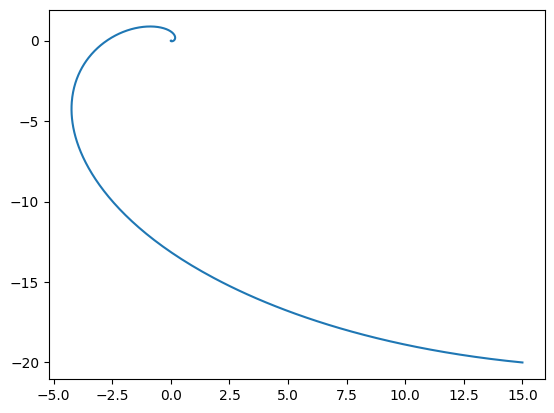

In [34]:
x = int.solve_ivp(ode_spiral, t_span = [0, 100], y0 = [15.0, -20.0], t_eval=time, method='RK45')
plt.plot(x.y[0], x.y[1])

In [53]:
data = torch.tensor(x.y).T.float()
t = torch.tensor(time).float()
data[0]

C:\Users\jackr\AppData\Local\Temp\ipykernel_20204\3612391766.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(time).float()


tensor([ 15., -20.])

In [134]:
# Training loop with gradient clipping for stability
epochs = 500
losses = []

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    pred_y = odeint(func=model, y0=data[0], t=t, method='rk4', options={'step_size':0.01})
    loss = loss_fn(pred_y, data)
    loss.backward()
    #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Add gradient clipping
    optimizer.step()
    losses.append(loss.item())
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

 10%|█         | 50/500 [03:41<32:56,  4.39s/it]

Epoch [50/500], Loss: 1.4227


 20%|██        | 100/500 [07:26<30:16,  4.54s/it]

Epoch [100/500], Loss: 1.0425


 30%|███       | 150/500 [11:12<26:26,  4.53s/it]

Epoch [150/500], Loss: 0.7687


 40%|████      | 200/500 [15:00<22:10,  4.43s/it]

Epoch [200/500], Loss: 0.5695


 50%|█████     | 250/500 [18:53<19:34,  4.70s/it]

Epoch [250/500], Loss: 0.4236


 60%|██████    | 300/500 [22:48<15:06,  4.53s/it]

Epoch [300/500], Loss: 0.3161


 70%|███████   | 350/500 [26:33<11:09,  4.46s/it]

Epoch [350/500], Loss: 0.2367


 80%|████████  | 400/500 [30:19<07:41,  4.61s/it]

Epoch [400/500], Loss: 0.1783


 90%|█████████ | 450/500 [34:09<03:48,  4.58s/it]

Epoch [450/500], Loss: 0.1355


100%|██████████| 500/500 [37:55<00:00,  4.55s/it]

Epoch [500/500], Loss: 0.1044


In [147]:
x0 = torch.tensor([-15.0, 20.0])

In [145]:
data[0]

tensor([ 15., -20.])

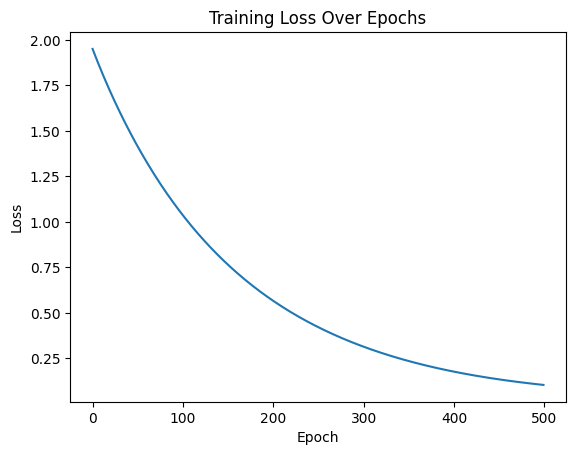

In [148]:
# Plot training loss
plt.plot(losses)
#plt.ylim(0, 1)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Generate predictions for visualization

new_x = odeint(func=model, y0=x0, t=t, method='rk4', options={'step_size':0.01})
new_x = new_x.detach().cpu().numpy()




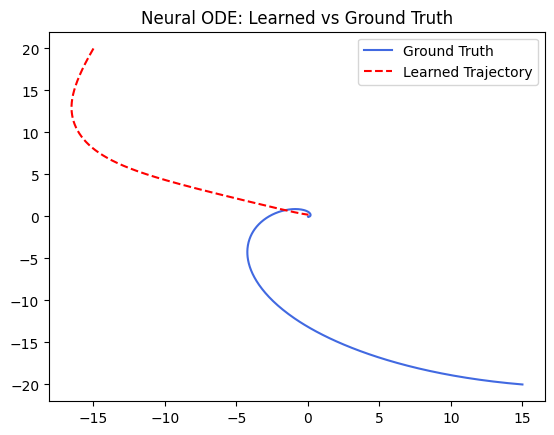

In [149]:
# Plot learned trajectory vs ground truth
plt.plot(x.y[0], x.y[1], label='Ground Truth', color='royalblue')
plt.plot(new_x[:, 0], new_x[:, 1], label='Learned Trajectory', color='r', linestyle='--')

plt.legend()
plt.title("Neural ODE: Learned vs Ground Truth")
plt.show()
